In [1]:
import numpy as np
from numpy.linalg import norm, solve, multi_dot
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
from scipy.linalg import hilbert

In [13]:
def laplacian(n):
    m = np.zeros([n, n])
    for i in range(n):
        m[i, i] = 2 
        if i > 0:
            m[i, i - 1] = -1 
        if i < n-1:
            m[i, i + 1] = -1
    return m

In [14]:
def CG(A, b, x0):
    n = A.shape[0]
    x = np.matrix(np.zeros([n, 1])) 
    r = A * x - b 
    p = -r 
    k = 0 
    while norm(r) > 1e-6 and k < n:
        q     = A * p
        t     = (p.T * q)
        s     = (r.T * r)
        alpha = (s / t)
        alpha = np.asscalar(alpha)  
        x     = x + alpha * p 
        r     = r + alpha * q
        beta  = np.asscalar((r.T * r) / s)
        p     = -r + beta * p 
        k     = k + 1
    return x, k, norm(r)

In [15]:
def comparison(cg_method, matrix_type):
    for n in [2**i for i in range(6)]:
        A = matrix_type(n) 
        b = np.ones([n, 1])
        x0 = np.zeros(n)
        x, iter_number, err = cg_method(A, b, x0) 
        x_system            = np.linalg.solve(A, b) 
        err_system          = norm(A * x_system - b) 
        print("n: {N}\t CG iter:{ITER}\t error:{ERR:6.2e}\t built-in error:{ERRSYS:6.2e}".format(
            N=n, ITER=iter_number,ERR=err, ERRSYS=err_system))

In [12]:
comparison(CG,hilbert)

n: 1	 CG iter:1	 error:0.00e+00	 built-in error:0.00e+00
n: 2	 CG iter:2	 error:7.71e-16	 built-in error:4.24e+00
n: 4	 CG iter:4	 error:1.63e-09	 built-in error:1.12e+02
n: 8	 CG iter:8	 error:4.63e-04	 built-in error:1.04e+05
n: 16	 CG iter:16	 error:1.85e-04	 built-in error:3.65e+08
n: 32	 CG iter:32	 error:4.75e-02	 built-in error:1.41e+09


In [16]:
comparison(CG,laplacian)

n: 1	 CG iter:1	 error:0.00e+00	 built-in error:0.00e+00
n: 2	 CG iter:1	 error:0.00e+00	 built-in error:3.16e+00
n: 4	 CG iter:2	 error:0.00e+00	 built-in error:1.25e+01
n: 8	 CG iter:4	 error:0.00e+00	 built-in error:5.45e+01
n: 16	 CG iter:8	 error:0.00e+00	 built-in error:2.67e+02
n: 32	 CG iter:16	 error:0.00e+00	 built-in error:1.40e+03


In [17]:
import numpy as np
from numpy.linalg import norm, solve, multi_dot
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar


"""
@def   : objective function 
@param : x is vector 
@return: a scalar
"""
def objective_func(x):
    return 100 * (x[1] - x[0]**2)**2 + (1 - x[0])**2

"""
@def   : gradient of objective function 
@param : x is vector 
@return: a vector 
"""
def grad_objective_func(x):
    return np.array([
        -400 * x[0] * (x[1] - x[0] ** 2) - 2 * (1 - x[0]),
        200 * (x[1] - x[0]**2)      
    ])


def hessian_func(x):
    return np.matrix([
        [-400*(x[1] - 3*x[0]**2) + 2, -400 * x[0]], [-400 * x[0], 200]
    ])

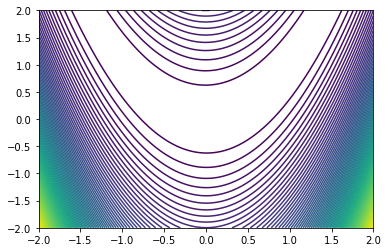

In [18]:
x = np.linspace(-2, 2, 500)
y = np.linspace(-2, 2, 500)
X, Y = np.meshgrid(x, y)

Z = objective_func([X,Y])

plt.contour(X, Y, Z, 90);

In [76]:
tol = 1e-9

def exact_line_search_quasi_newton(update_method, x0, H0):
    k = 0
    xcoords = [x0[0]]
    ycoords = [x0[1]]
    x_k = x0 
    H_k = H0 
    g_k = grad_objective_func(x_k)
    while norm(g_k) > tol:
        p_k = -np.matmul(H_k, g_k)                # search direction
   
        def subproblem1D(alpha):                  # for exact line search
            return objective_func(x_k + alpha * p_k)
        
        res = minimize_scalar(subproblem1D)
        alpha_k = res.x 

        s_k     = alpha_k * p_k                   # s_k = x_{k+1} - x_k 
        g_k1    = grad_objective_func(x_k + s_k)  # gk1 is g_{k+1}
        y_k     = g_k1 - g_k                      # y_k = g_{k+1} - g_(k)
        
        k = k + 1                                 # increment.
        """
        Here we transform matrix to ndarray, using .A 
        For interested readers. Here is the manual.
        see https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.matrix.html
        """
        H_k = update_method(H_k, s_k, y_k).A      
        x_k = x_k + s_k 
        g_k = g_k1
        
        xcoords.append(x_k[0])
        ycoords.append(x_k[1])
        
    return x_k, k, norm(g_k), xcoords, ycoords

In [99]:
def SR1(H, s_k, y_k):
    z = s_k - np.dot(H, y_k) 
    # the numerator is a matrix!
    numer = np.matrix(z).T * np.matrix(z)
    denom = np.dot(z, y_k)
    # when the denominator is too small, we skip the iteration.
    if np.abs(denom) < 10**(-8) * norm(z) * norm(y_k):
        return H
    else:
        return H + numer/denom 

In [100]:
x0 = np.array([1.2, -1])
H0 = np.eye(2)

x, iter_number, err, xcoords, ycoords = exact_line_search_quasi_newton(SR1, x0, H0)

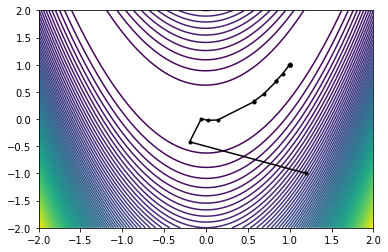

In [101]:
x = np.linspace(-2, 2, 500)
y = np.linspace(-2, 2, 500)
X, Y = np.meshgrid(x, y)

# evaluate function
Z = objective_func([X,Y])

plt.contour(X, Y, Z, 90);
plt.plot(xcoords, ycoords, '-k', marker='.')

In [113]:
def BFGS(H, s_k, y_k):
    p = 1/np.matmul(y_k.T,s_k)
    n = len(H)
    p = np.asscalar(p)
    s_k = np.matrix(s_k)
    y_k = np.matrix(y_k)
    F = np.matrix(np.eye(n) - (p * s_k.T * y_k))
    B = np.matrix(np.eye(n) - (p * y_k.T * s_k))
    L = p * s_k.T*s_k
    return (F*H*B+L)

In [114]:
x0 = np.array([1.2, -1])
H0 = np.eye(2)

x, iter_number, err, xcoords, ycoords = exact_line_search_quasi_newton(BFGS, x0, H0)

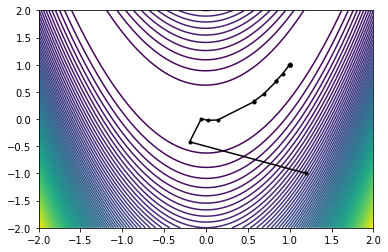

In [115]:
x = np.linspace(-2, 2, 500)
y = np.linspace(-2, 2, 500)
X, Y = np.meshgrid(x, y)

# evaluate function
Z = objective_func([X,Y])

plt.contour(X, Y, Z, 90);
plt.plot(xcoords, ycoords, '-k', marker='.')